In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force rreimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']


from pygents.token import Tokenizer 
from pygents.text import *
from pygents.util import count_subelements, dictcount, calc_f1, counters_init, countcount
from pygents.plot import plot_bars 


In [2]:
# checking for pre-requisites

assert str(Tokenizer().tokenize("ab c")) == "['ab', 'c']"
assert calc_f1(['ab','cd','ef','gh'],['abcd','ef','gh']) == 0.5714285714285715


In [3]:
#TODO list(text) => text



In [4]:
#TODO move out to module

class FreedomTokenizer(Tokenizer):

    def __init__(self, name=None, max_n=7, mode='grams', debug=False):
        Tokenizer.__init__(self,debug=debug)
        self.max_n = max_n
        self.model = pickle.load(open(name, 'rb')) if name is not None else [{},{},{}]
        self.mode = mode

    def train(self,texts,max_n=None):
        if max_n is None:
            max_n = self.max_n
        model = counters_init(max_n) 
        for text in texts:
            text = preprocess_text(text)
            if self.mode == 'grams':
                for n in range(max_n):
                    grams_count_with_gram_freedoms(model,text,n+1,debug=self.debug)
            else: # 'chars' - legacy
                chars = list(text)
                for n in range(max_n):
                    grams_count_with_char_freedoms(model[0],model[1],model[2],chars,n+1,debug=self.debug)
        #merge n-specific models into joint ones
        for i in range(3):
            for d in model[i]:
                self.model[i].update(d)
        return self
        
    def tokenize(self,text):
        #TODO
        return text.split()

    def count_params(self):
        return count_subelements(self.model)
    
    def store(self,path):
        pickle.dump(self.model, open(path, 'wb'), pickle.HIGHEST_PROTOCOL)

    
_test_tokenizer = FreedomTokenizer(max_n=2,mode='chars',debug=False).train(["pig"])
assert _test_tokenizer.count_params() == 11
assert str(_test_tokenizer.model) == "[{'p': 1, 'i': 1, 'g': 1, 'pi': 1, 'ig': 1}, {'p': {'i': 1}, 'i': {'g': 1}, 'pi': {'g': 1}}, {'i': {'p': 1}, 'g': {'i': 1}, 'ig': {'p': 1}}]"
_test_tokenizer = FreedomTokenizer(max_n=2,mode='chars').train(["ding","dong"])
#print(_test_tokenizer.count_params())
assert _test_tokenizer.count_params() == 28
#print(str(_test_tokenizer.model[0]))
#print(str(_test_tokenizer.model[1]))
#print(str(_test_tokenizer.model[2]))
#print(str(_test_tokenizer.model))
assert str(_test_tokenizer.model) == "[{'d': 2, 'i': 1, 'n': 2, 'g': 2, 'o': 1, 'di': 1, 'in': 1, 'ng': 2, 'do': 1, 'on': 1}, {'d': {'i': 1, 'o': 1}, 'i': {'n': 1}, 'n': {'g': 2}, 'o': {'n': 1}, 'di': {'n': 1}, 'in': {'g': 1}, 'do': {'n': 1}, 'on': {'g': 1}}, {'i': {'d': 1}, 'n': {'i': 1, 'o': 1}, 'g': {'n': 2}, 'o': {'d': 1}, 'in': {'d': 1}, 'ng': {'i': 1, 'o': 1}, 'on': {'d': 1}}]"


In [60]:
text = "abc1abc2"

_test_chars = FreedomTokenizer(max_n=2,mode='chars',debug=False).train([text])
print(_test_chars.count_params())
print(_test_chars.model[2])

_test_grams = FreedomTokenizer(max_n=2,mode='grams',debug=False).train([text])
print(_test_grams.count_params())
print(_test_grams.model[2])


30
{'b': {'a': 2}, 'c': {'b': 2}, '1': {'c': 1}, 'a': {'1': 1}, '2': {'c': 1}, 'bc': {'a': 2}, 'c1': {'b': 1}, '1a': {'c': 1}, 'ab': {'1': 1}, 'c2': {'b': 1}}
32
{'b': {'a': 2}, 'c': {'b': 2}, '1': {'c': 1}, 'a': {'1': 1}, '2': {'c': 1}, 'bc': {'a': 1, '1a': 1}, 'c1': {'ab': 1}, '1a': {'bc': 1}, 'ab': {'c1': 1}, 'c2': {'ab': 1}}


In [5]:
to = FreedomTokenizer(max_n=7,debug=False).train(["i like skiing","you love riding","they prefer diving"])
l = profile_freedoms(to.model,"you prefer diving",1,debug=True)


+1-1:	'o'=>o	2	-1-2:	'o'=>o	2
+2-2:	'u'=>u	1	-2-3:	'u'=>u	1
+3-3:	' '=> 	5	-3-4:	' '=> 	5
+4-4:	'p'=>p	1	-4-5:	'p'=>p	1
+5-5:	'r'=>r	3	-5-6:	'r'=>r	3
+6-6:	'e'=>e	4	-6-7:	'e'=>e	5
+7-7:	'f'=>f	1	-7-8:	'f'=>f	1
+8-8:	'e'=>e	4	-8-9:	'e'=>e	5
+9-9:	'r'=>r	3	-9-10:	'r'=>r	3
+10-10:	' '=> 	5	-10-11:	' '=> 	5
+11-11:	'd'=>d	1	-11-12:	'd'=>d	2
+12-12:	'i'=>i	6	-12-13:	'i'=>i	6
+13-13:	'v'=>v	2	-13-14:	'v'=>v	2
+14-14:	'i'=>i	6	-14-15:	'i'=>i	6
+15-15:	'n'=>n	1	-15-16:	'n'=>n	1


In [62]:
# Brown Corpus
# http://www.sls.hawaii.edu/bley-vroman/brown_corpus.html
# http://www.sls.hawaii.edu/bley-vroman/brown_nolines.txt

brown_text = url_text("http://www.sls.hawaii.edu/bley-vroman/brown_nolines.txt")
print(len(brown_text))

19810
6006249


In [63]:
brown_chars = FreedomTokenizer(max_n=7,mode='chars',debug=False).train([brown_text])
print(brown_chars.count_params())

brown_grams = FreedomTokenizer(max_n=7,mode='grams',debug=False).train([brown_text])
print(brown_grams.count_params())


10967135
33960499


In [64]:
brown_chars.store('data/models/brown_nolines_chars_7a')
brown_grams.store('data/models/brown_nolines_grams_7a')
#pickle.dump(brown_to.model, open('data/models/brown_nolines_7a', 'wb'), pickle.HIGHEST_PROTOCOL)


In [125]:
def profile_freedoms_ex_df(model,text,n,debug=False):
    df = pd.DataFrame(profile_freedoms(model,text,n,debug=debug),columns=['pos','gram','f+','f-'])
    df['ddf+'] = (df['f+'] - df['f+'].mean()).clip(lower=0)
    df['ddf-'] = (df['f-'] - df['f-'].mean()).clip(lower=0)
    df['ddf+|ddf-'] = df['ddf+'] + df['ddf-'].shift(-1)
    df['ddf+&ddf-'] = df['ddf+'] * df['ddf-'].shift(-1)
    df['df+'] = df['f+'].diff() 
    df['df-'] = -df['f-'].diff().shift(-1)
    df['df+|df-'] = df['df+'] + df['df-']
    df['df+&df-'] = df['df+'] * df['df-']
    # We assigned a “peak” value to each character transition, 
    # computed by adding the value of the preceding increase in freedom to the following decrease in freedom. 
    # We characterized token boundaries based on the sum of their forward- and backward-reading peak values.
    df['peak+'] = df['df+'] - df['df+'].shift(-1)
    df['peak-'] = df['df-'] - df['df-'].shift(1)
    df['f+|f-'] = df['f+'] + df['f-'].shift(-1)
    df['f+&f-'] = df['f+'] * df['f-'].shift(-1)
    return df


def profile_freedoms_avg_df(model,text,metrics,nlist,debug=False):
    res_df = None
    for n in nlist:
        df = profile_freedoms_ex_df(model,text,n)
        if res_df is None:
            res_df = df[['pos','gram']+metrics].copy()
        else:
            for m in metrics:
                res_df[m] = res_df[m] + df[m]
    for m in metrics:
        res_df[m] = res_df[m]/res_df[m].max()
    return res_df



['una', ' ', 'is', ' ', 'a', ' ', 'fish', '.', ' ', 'cat', ' ', 'is', ' ', 'a', ' ', 'mammal', '.', ' ', 'eagle', ' ', 'is', ' ', 'a', ' ', 'bird', '.', ' ', "that's", ' ', 'it']


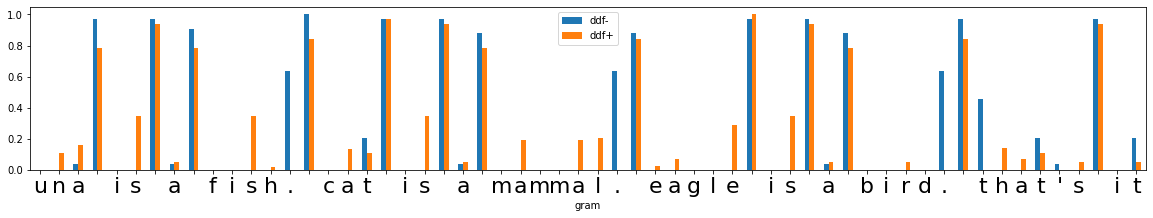

In [150]:
#TODO add first and last symbols to profile

def tokenize_with_opposite_metrics(model,text,back,forw,nlist,threshold=0.5,debug=False):
    tokens = []
    token = ''
    df = profile_freedoms_avg_df(model,text,[forw,back],nlist)
    length = len(df)
    for i in range(length):
        iplus1 = i+1
        brk_back = True if iplus1 < length and df.loc[iplus1][back] >= threshold else False
        brk_forw = True if df.loc[i][forw] >= threshold else False
        token += df.loc[i]['gram']
        if debug:
            print("{}\t{}\t{}\t{}\t{}\t{}".format(df.loc[i]['gram'],'-' if brk_back else '', '+' if brk_forw else '',round(df.loc[i][back],2),round(df.loc[i][forw],2),token))
        if len(token) > 0 and (brk_back or brk_forw):
            tokens.append(token)
            token = ''
    if len(token) > 0:
            tokens.append(token)
    return tokens
    
#text = "fish. cat" 
text = "tuna is a fish. cat is a mammal. eagle is a bird. that's it." 
tokens = tokenize_with_opposite_metrics(brown_chars.model,text.lower(),'ddf-','ddf+',[1,2])
print(tokens)

df = profile_freedoms_avg_df(brown_chars.model,text.lower(),['f-','f+','ddf-','ddf+','ddf+|ddf-'],[1,2])
plot_bars(df,'gram',['ddf-','ddf+'])


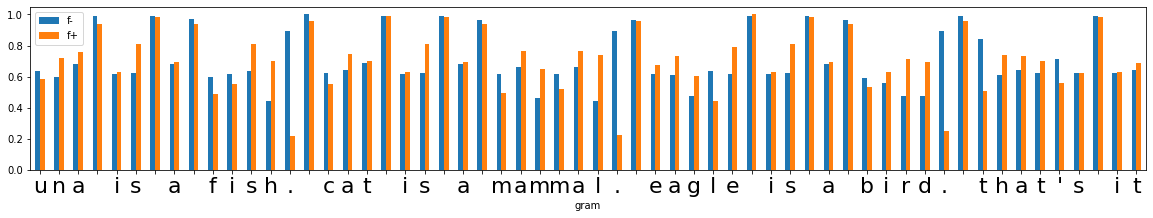

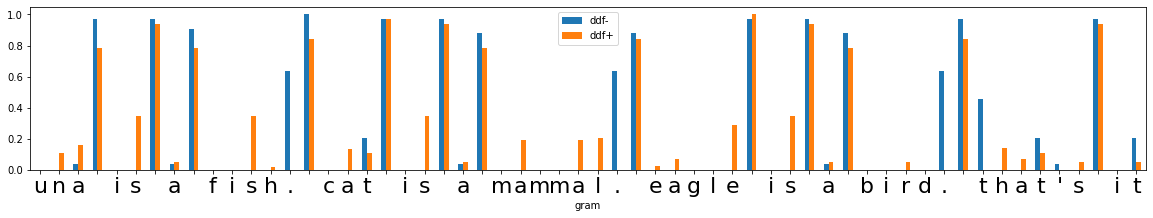

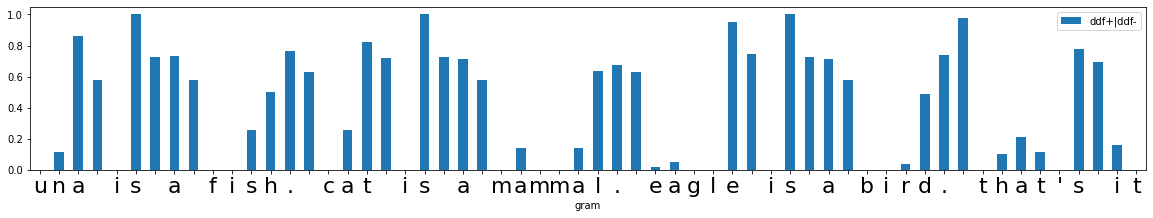

In [128]:
text = "tuna is a fish. cat is a mammal. eagle is a bird. that's it." 
df = profile_freedoms_avg_df(brown_chars.model,text.lower(),['f-','f+','ddf-','ddf+','ddf+|ddf-'],[1,2])
plot_bars(df,'gram',['f-','f+'])
plot_bars(df,'gram',['ddf-','ddf+'])
plot_bars(df,'gram',['ddf+|ddf-'])


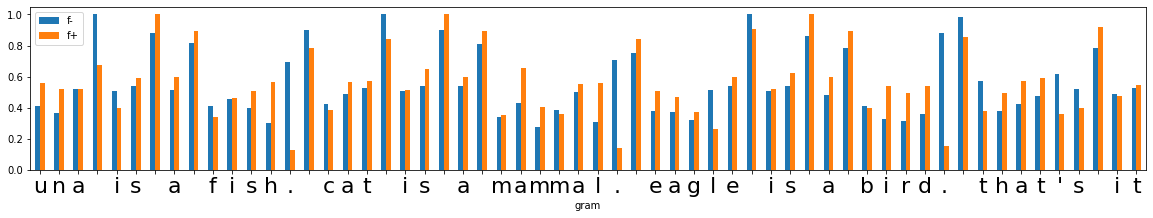

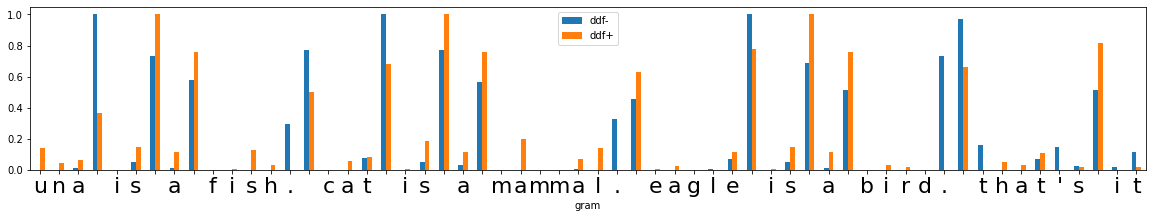

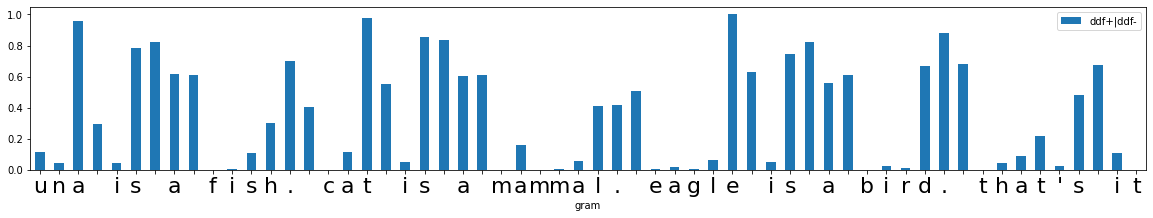

In [127]:
text = "tuna is a fish. cat is a mammal. eagle is a bird. that's it." 
df = profile_freedoms_avg_df(brown_chars.model,text.lower(),['f-','f+','ddf-','ddf+','ddf+|ddf-'],[1,2,3,4])
plot_bars(df,'gram',['f-','f+'])
plot_bars(df,'gram',['ddf-','ddf+'])
plot_bars(df,'gram',['ddf+|ddf-'])


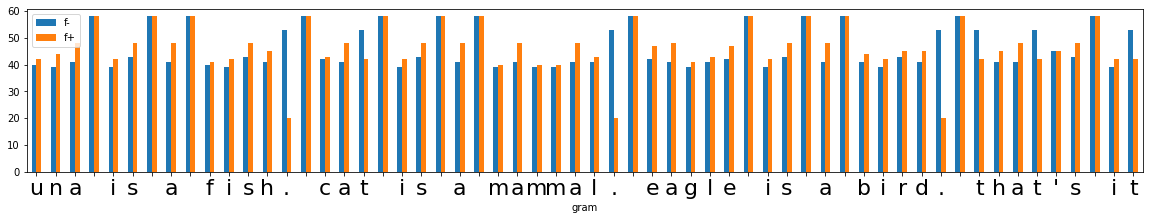

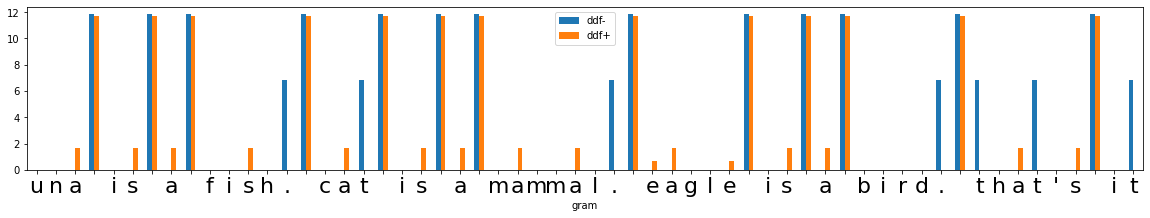

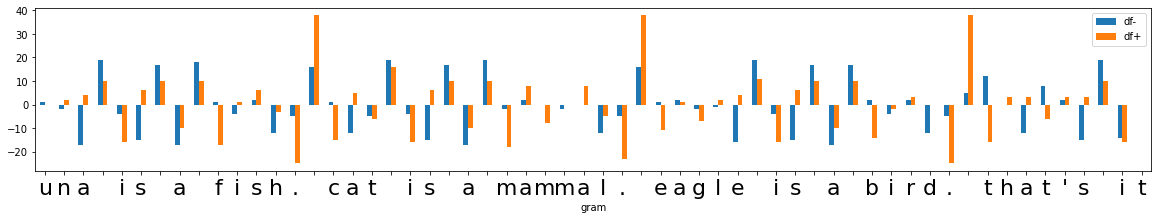

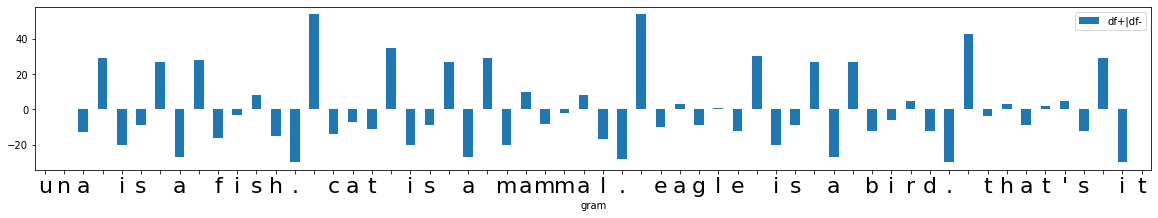

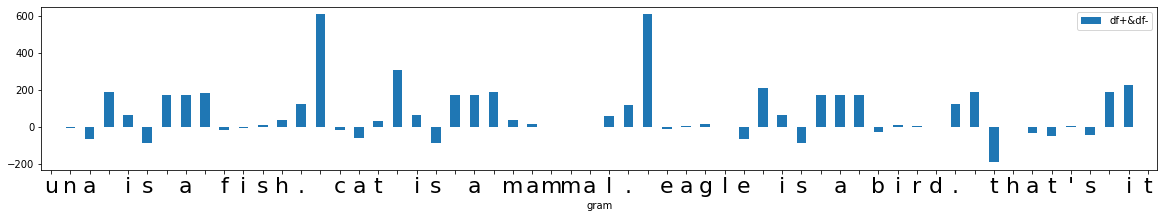

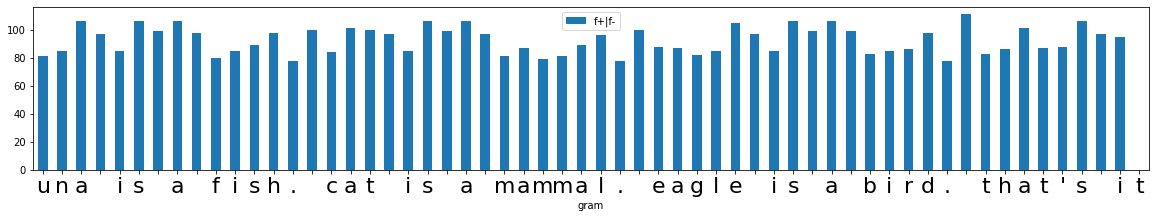

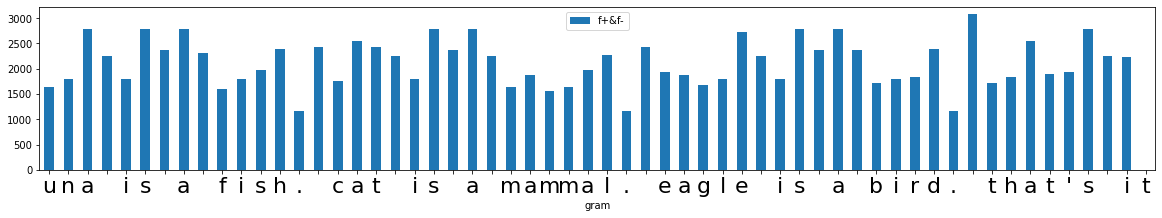

In [89]:
text = "tuna is a fish. cat is a mammal. eagle is a bird. that's it." 
df = profile_freedoms_ex_df(brown_chars.model,text.lower(),1)
plot_bars(df,'gram',['f-','f+'])
plot_bars(df,'gram',['ddf-','ddf+'])
plot_bars(df,'gram',['df-','df+'])
plot_bars(df,'gram',['df+|df-'])
plot_bars(df,'gram',['df+&df-'])
plot_bars(df,'gram',['f+|f-'])
plot_bars(df,'gram',['f+&f-'])


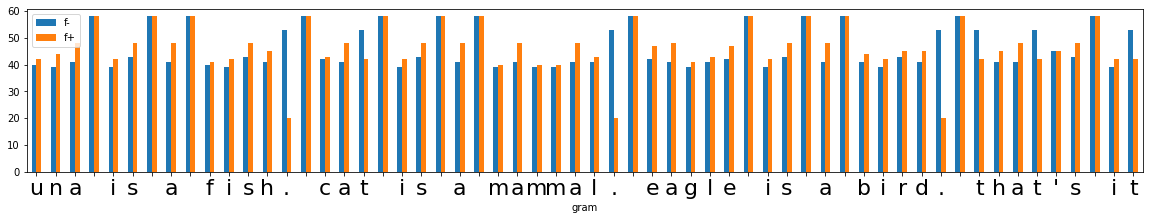

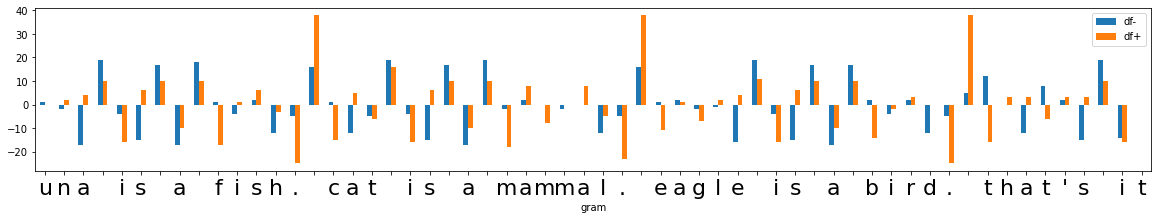

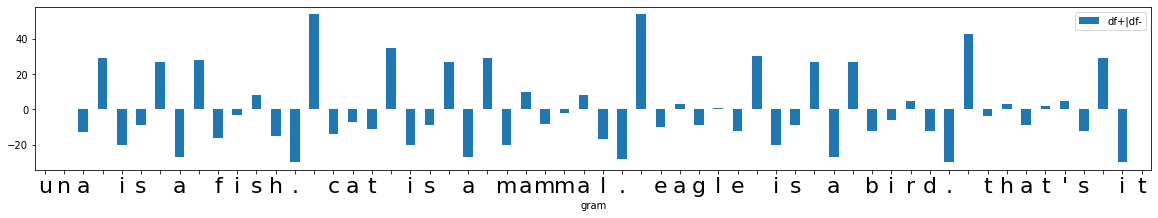

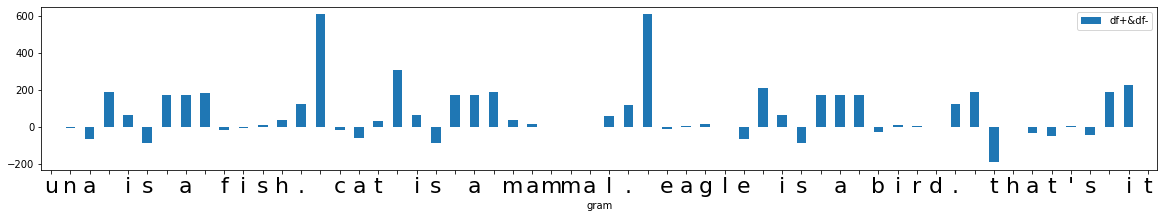

In [90]:
text = "tuna is a fish. cat is a mammal. eagle is a bird. that's it." 
df = profile_freedoms_ex_df(brown_grams.model,text.lower(),1)
plot_bars(df,'gram',['f-','f+'])
plot_bars(df,'gram',['df-','df+'])
plot_bars(df,'gram',['df+|df-'])
plot_bars(df,'gram',['df+&df-'])

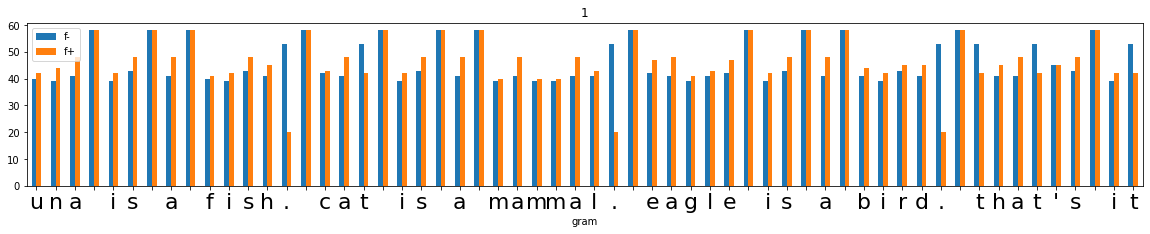

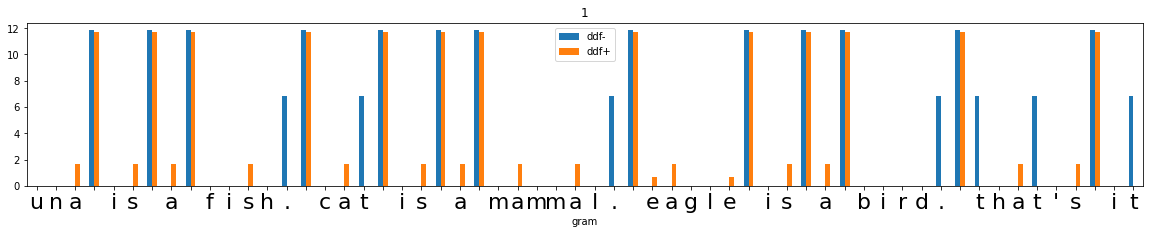

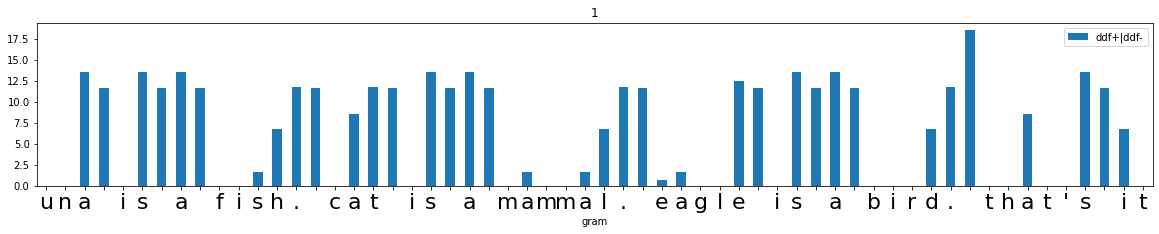

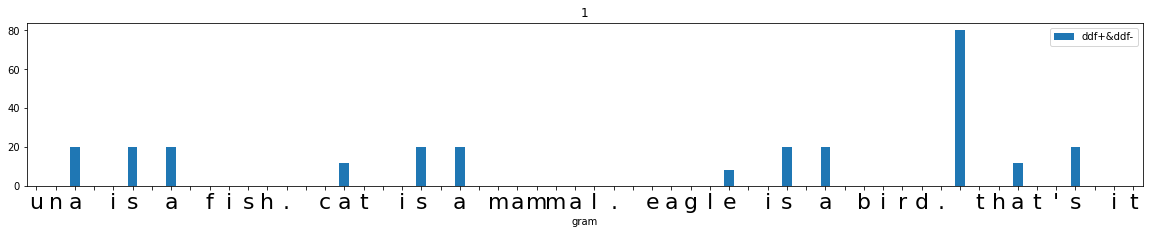

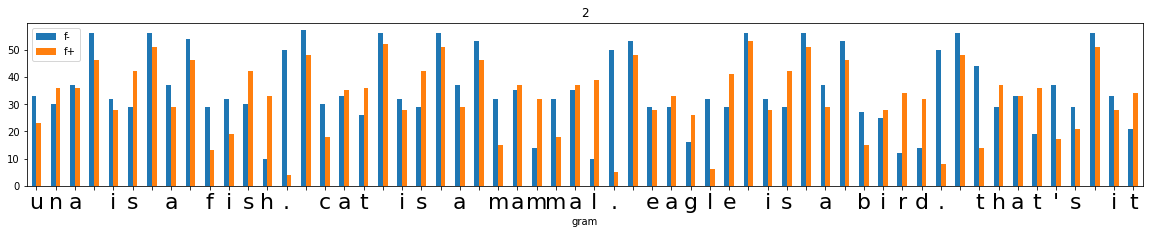

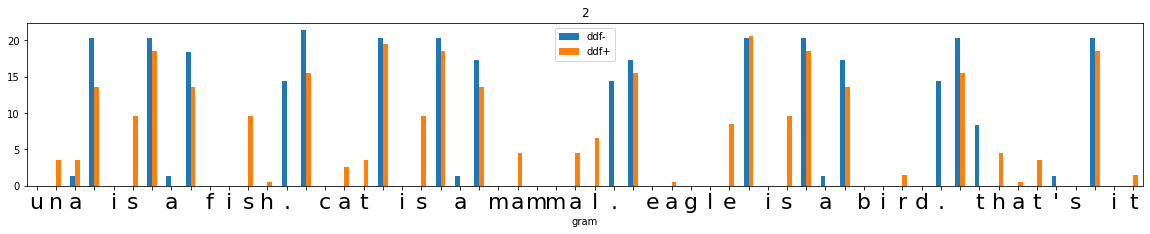

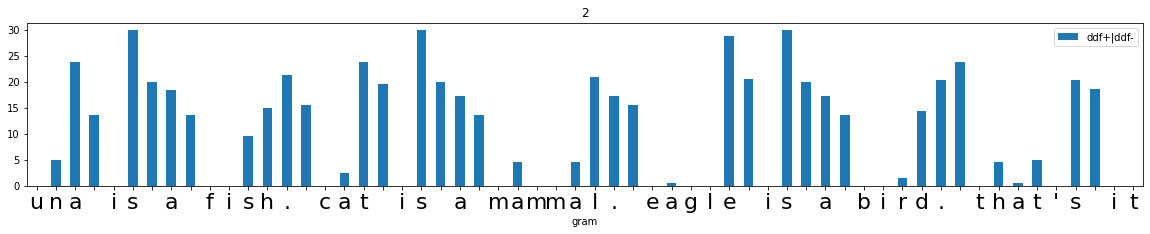

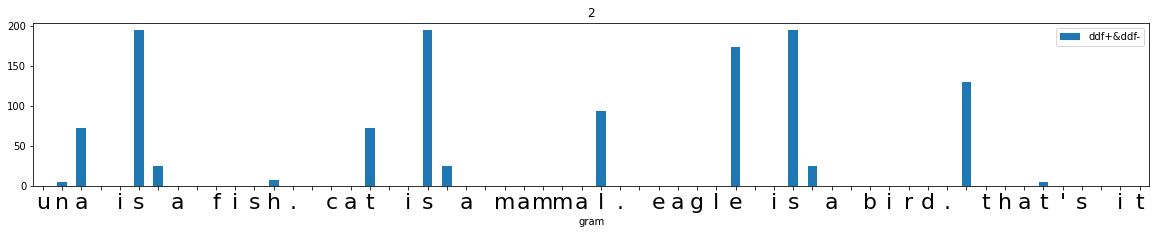

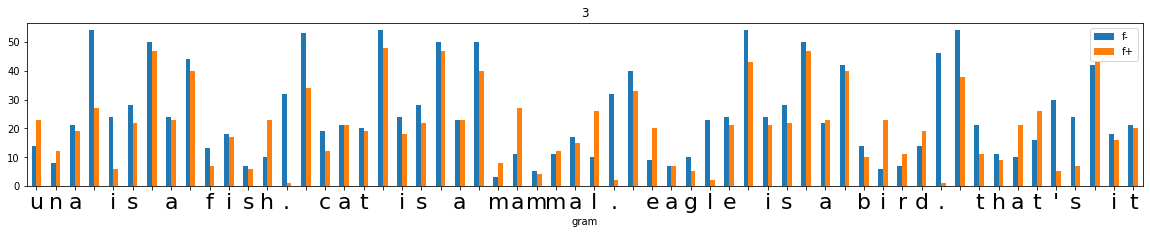

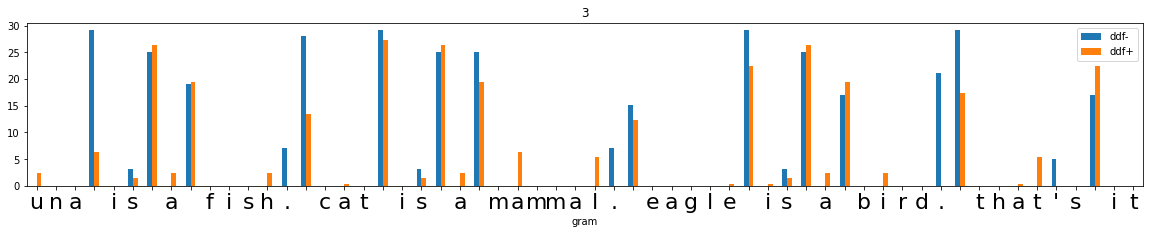

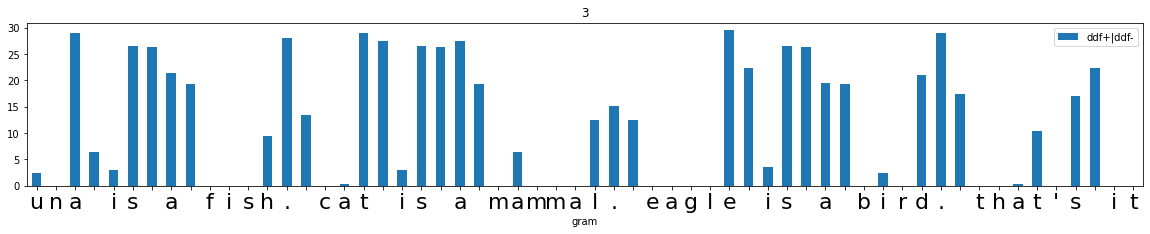

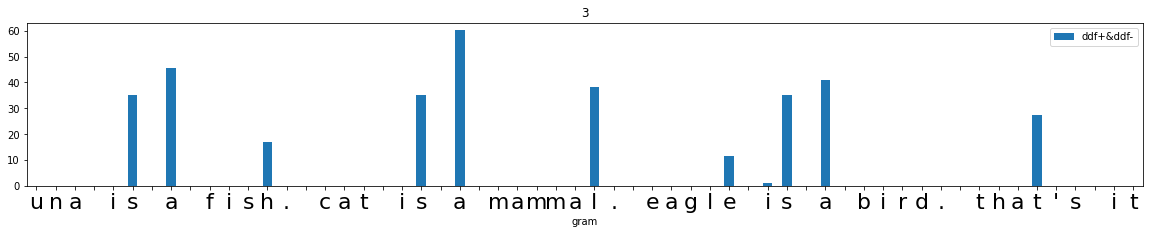

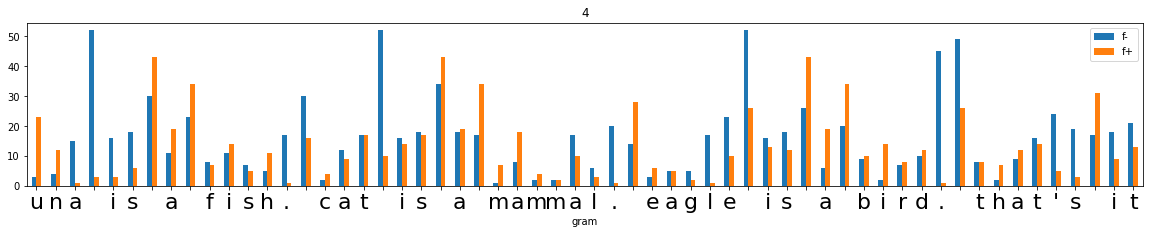

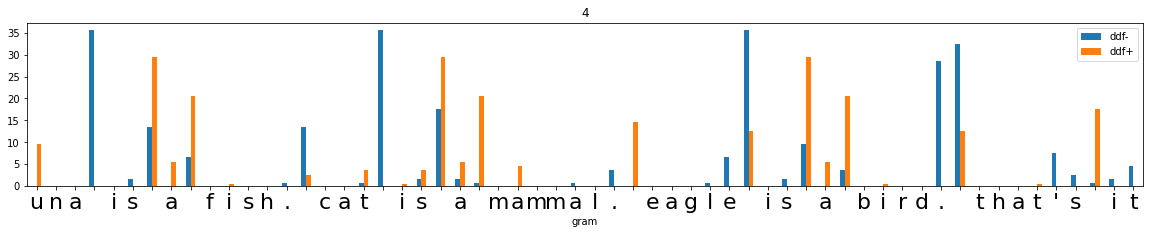

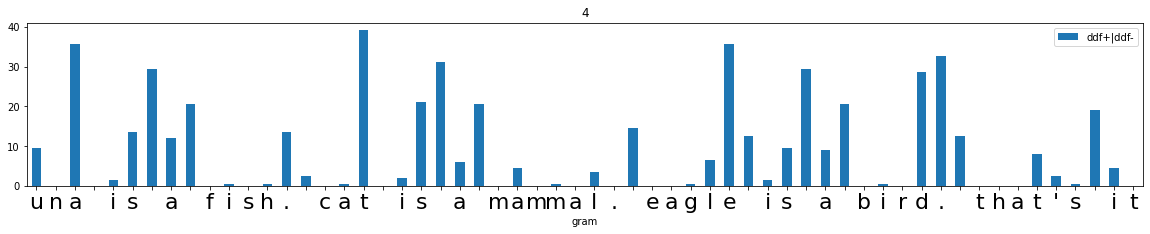

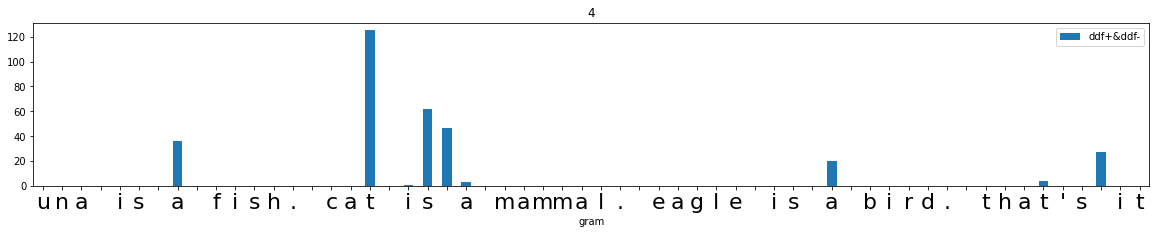

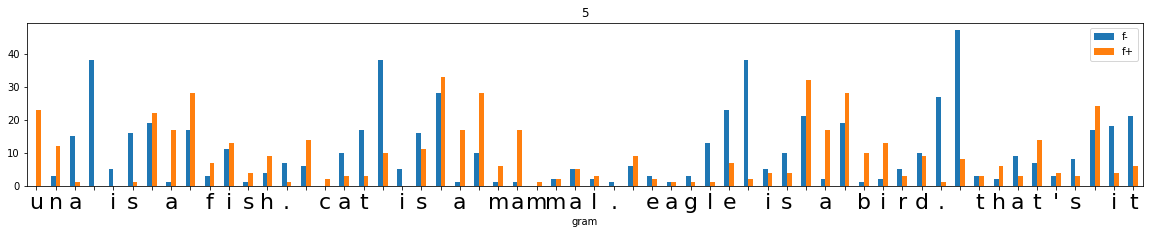

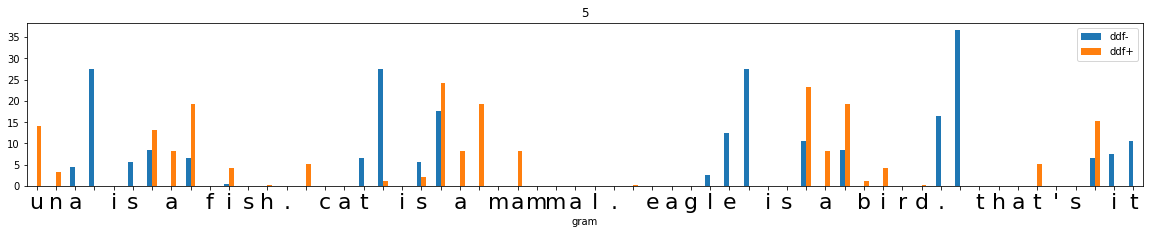

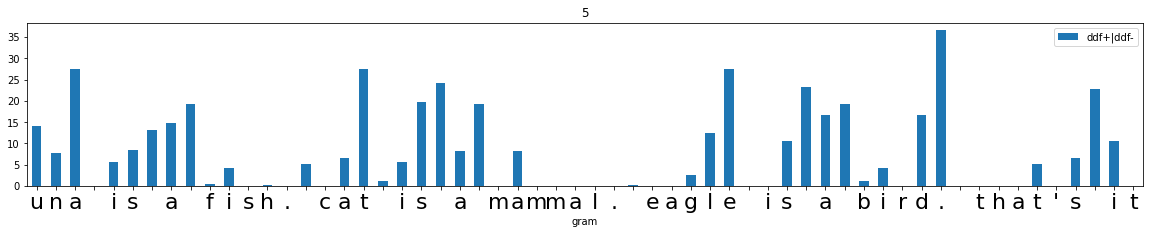

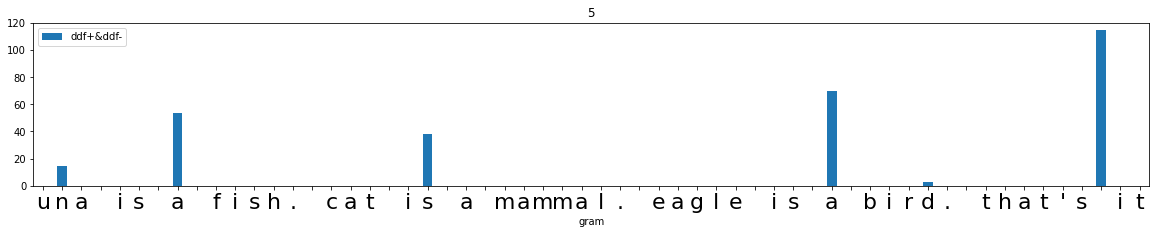

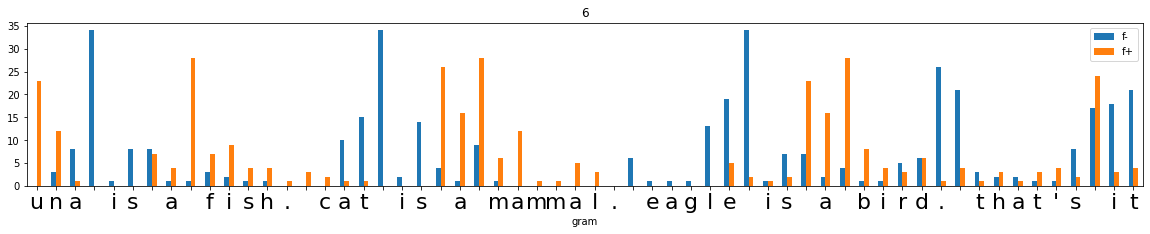

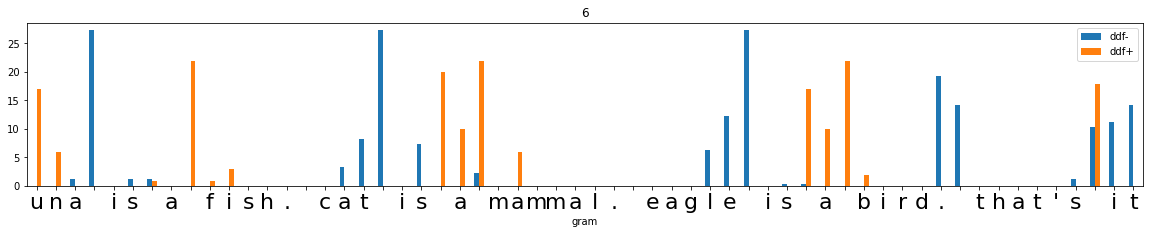

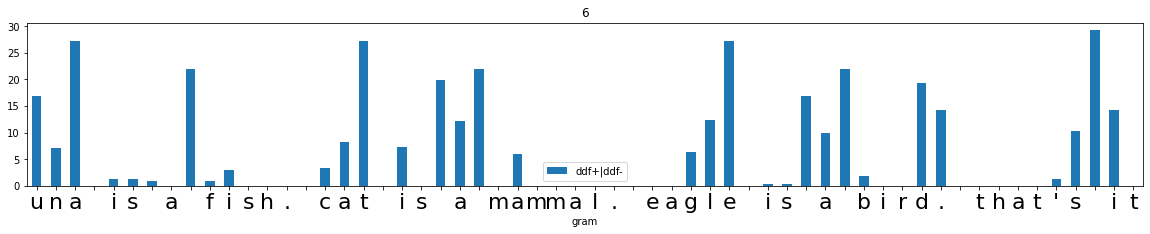

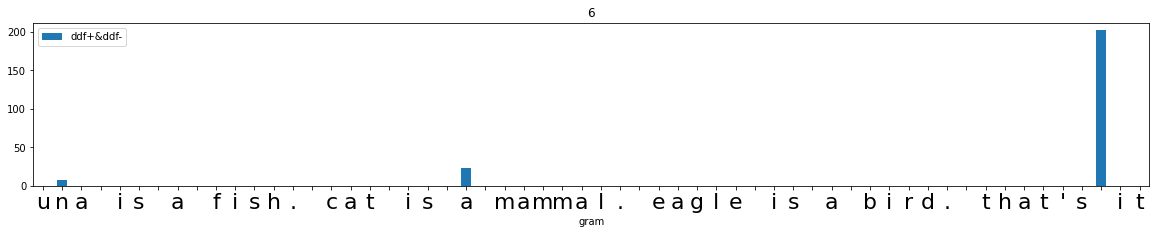

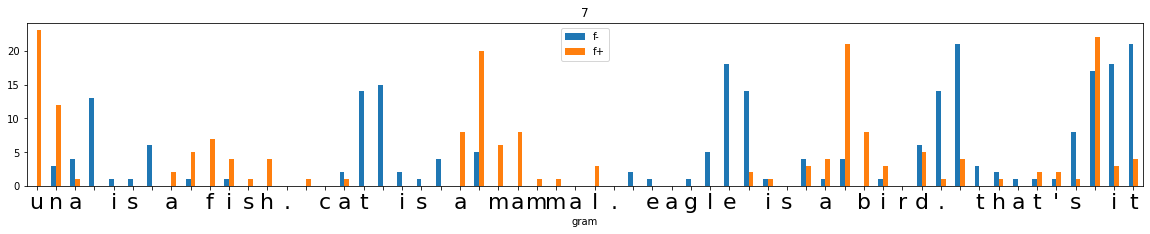

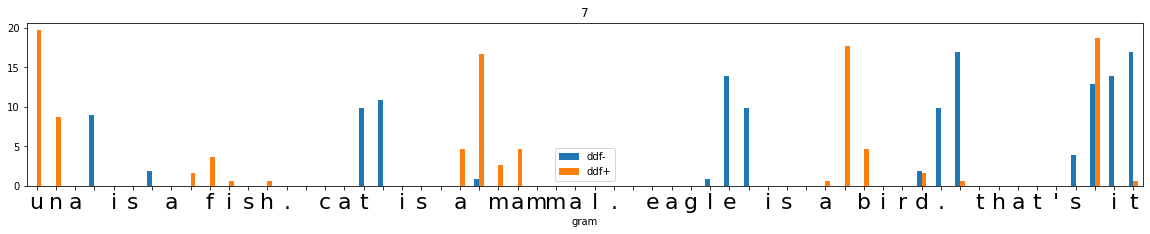

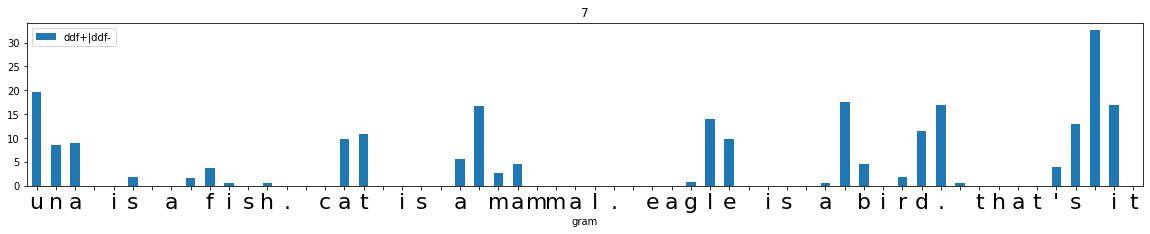

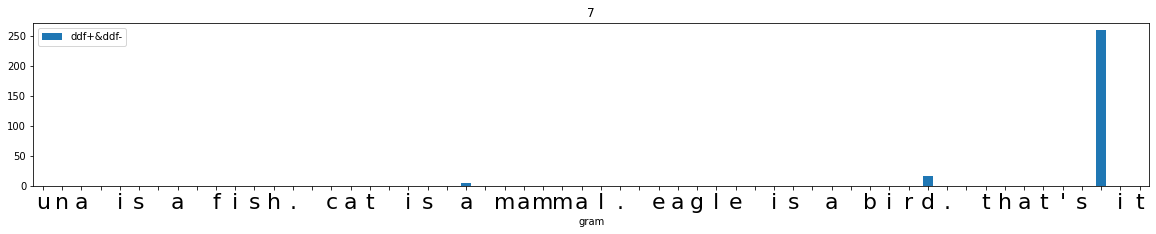

In [98]:
for i in range(1,7+1):
    df = profile_freedoms_ex_df(brown_chars.model,text.lower(),i)
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['ddf+|ddf-'],title=str(i))
    plot_bars(df,'gram',['ddf+&ddf-'],title=str(i))
    #plot_bars(df,'gram',['df-','df+'],title=str(i))
    #plot_bars(df,'gram',['df+|df-'],title=str(i))
    #plot_bars(df,'gram',['df+&df-'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))
    #plot_bars(df,'gram',['f+|f-'],title=str(i))
    #plot_bars(df,'gram',['f+&f-'],title=str(i))


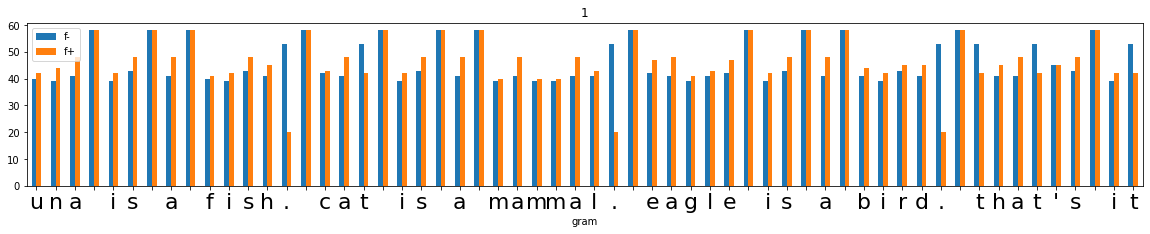

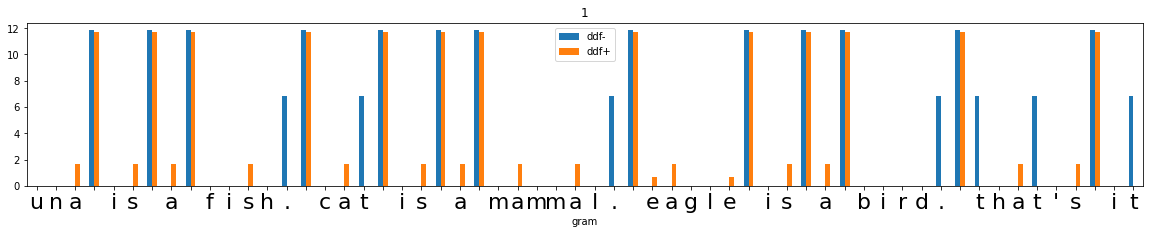

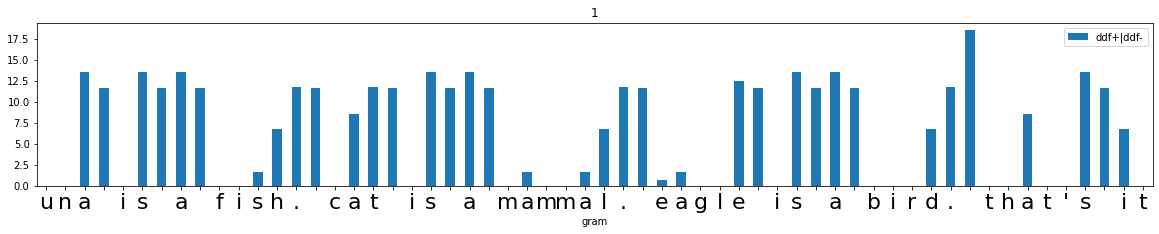

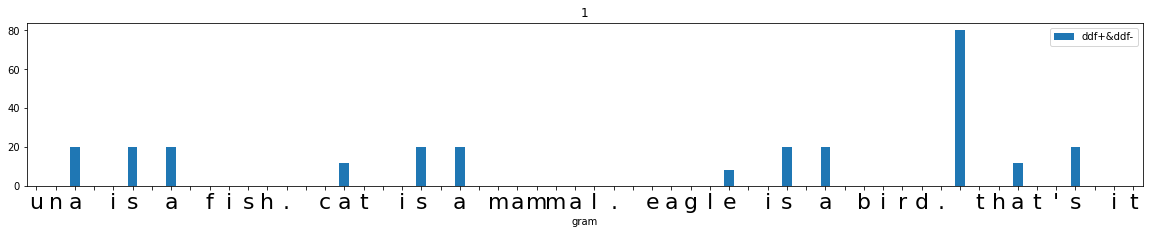

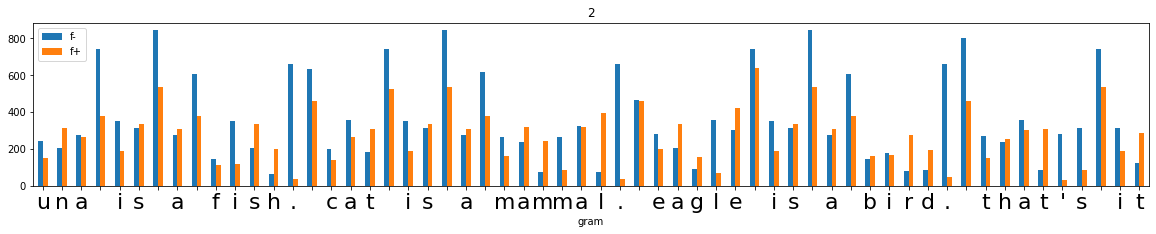

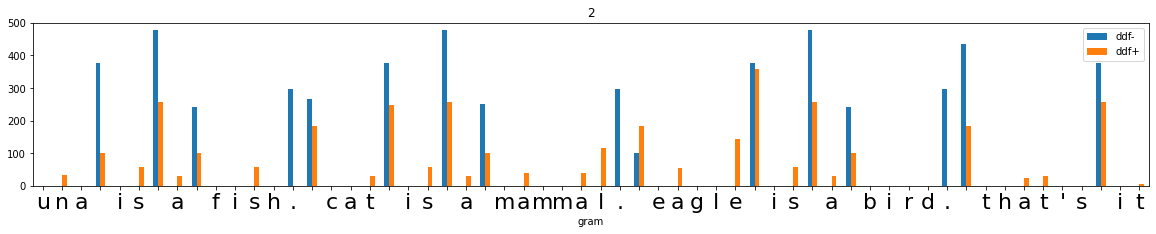

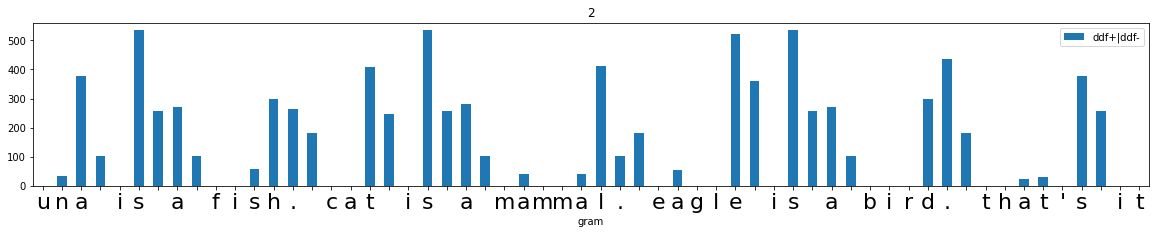

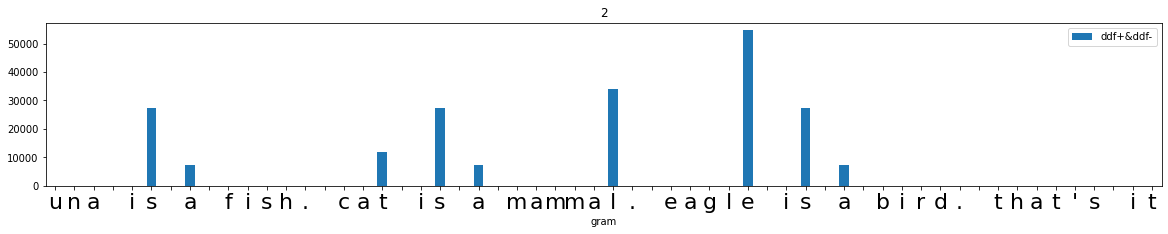

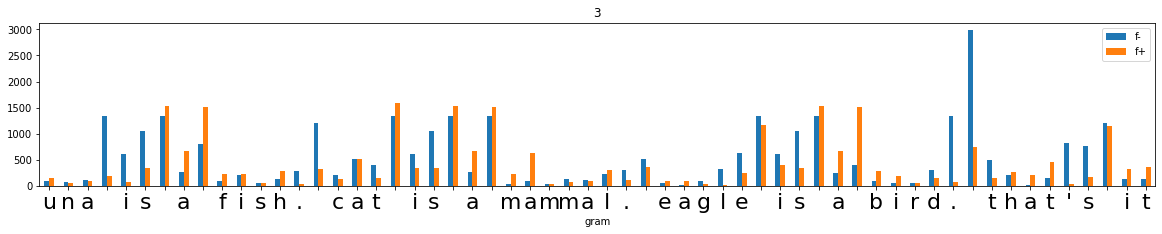

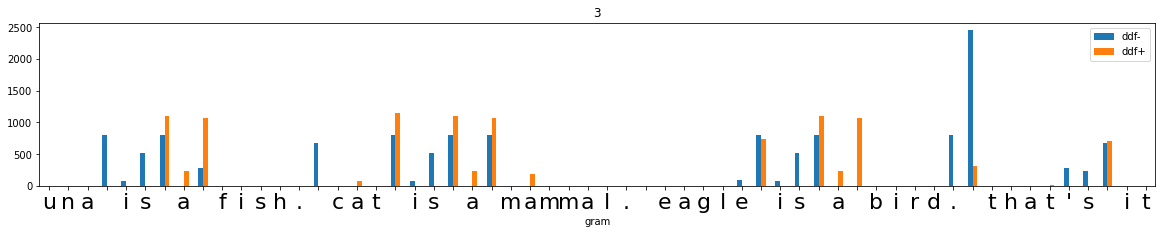

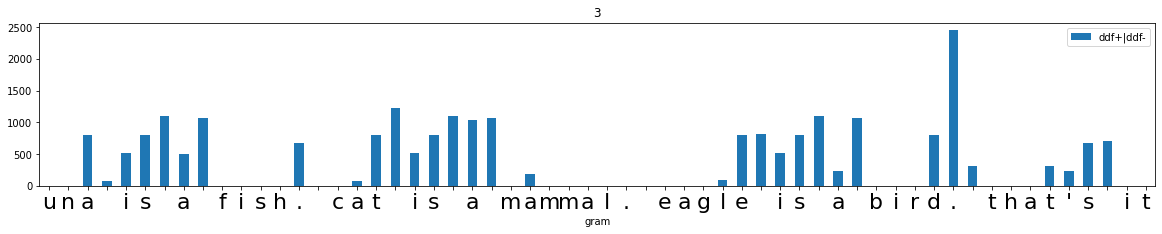

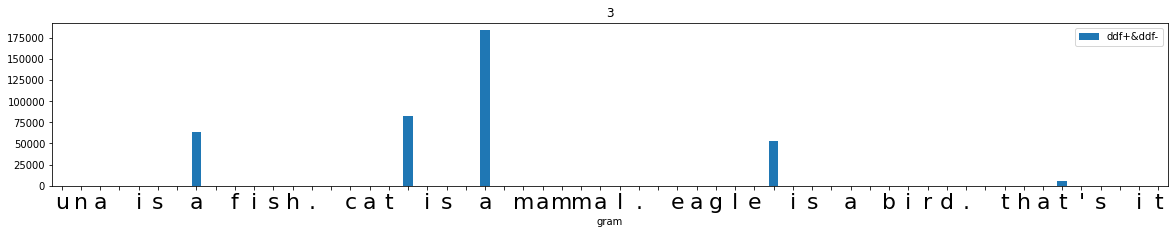

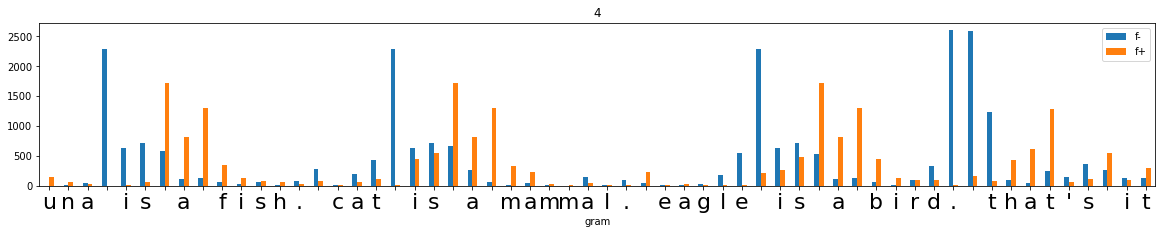

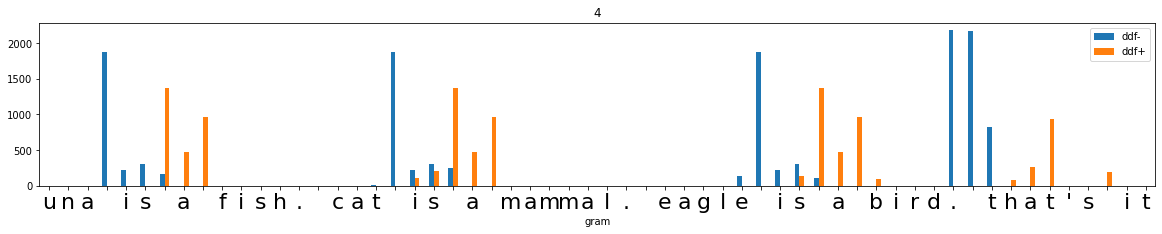

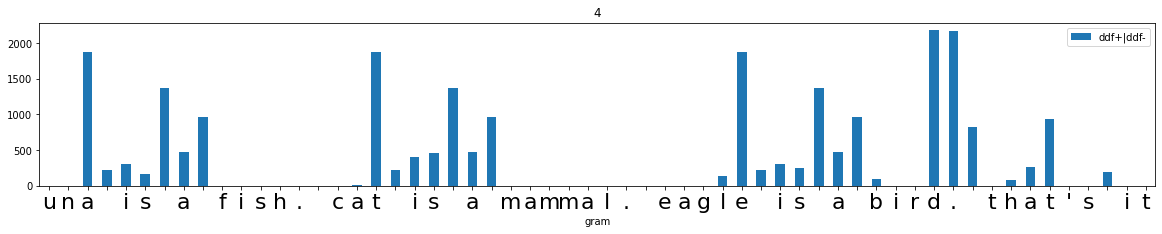

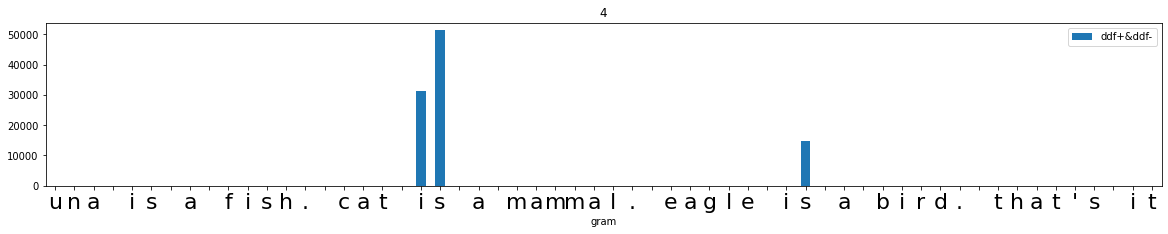

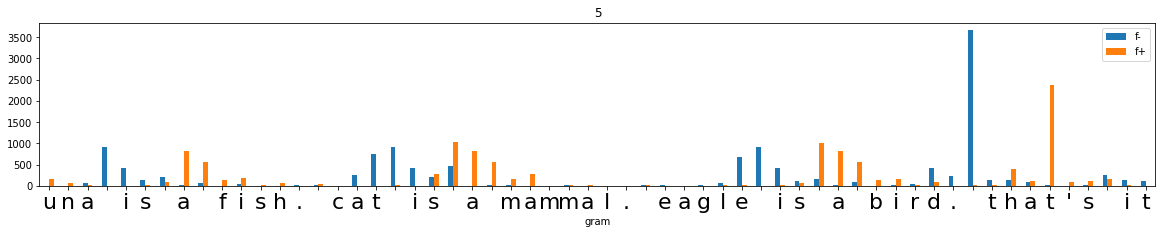

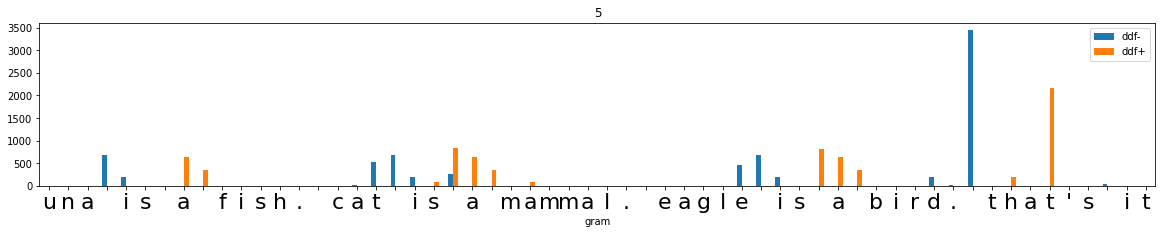

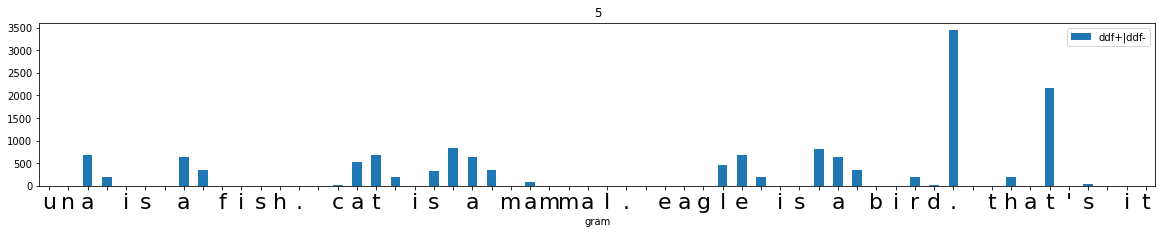

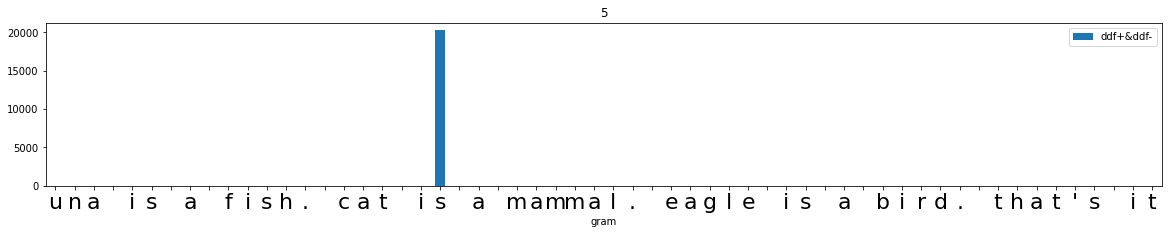

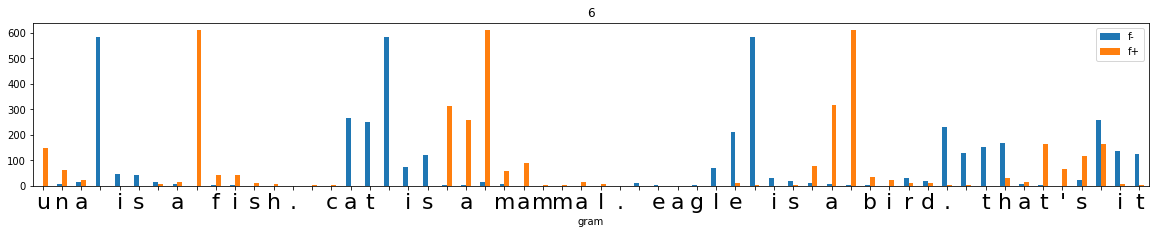

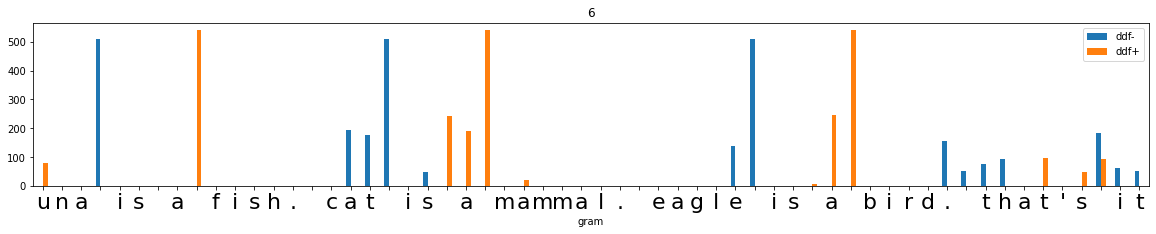

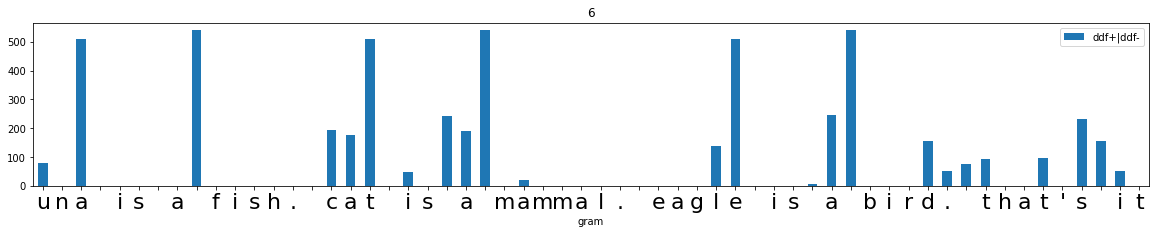

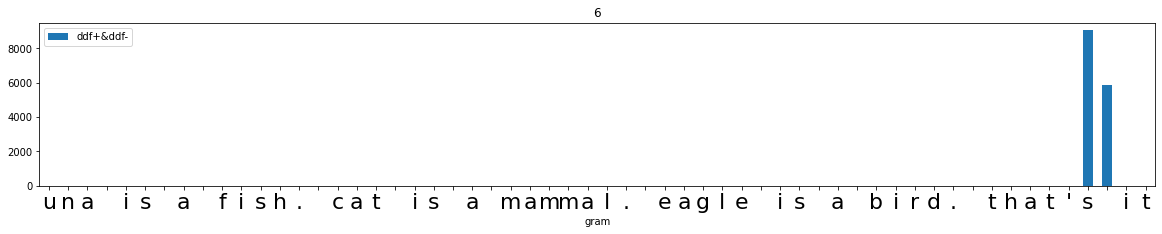

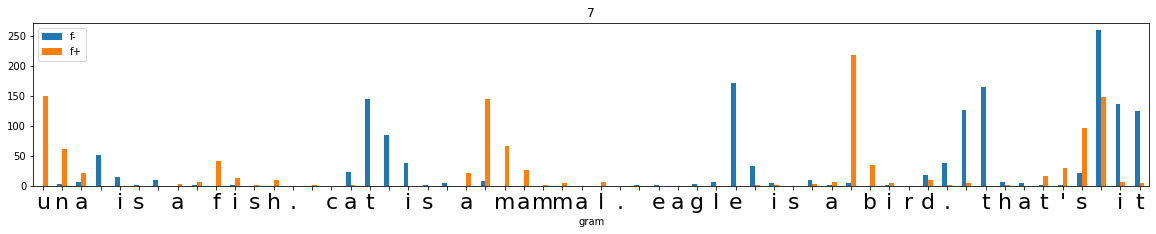

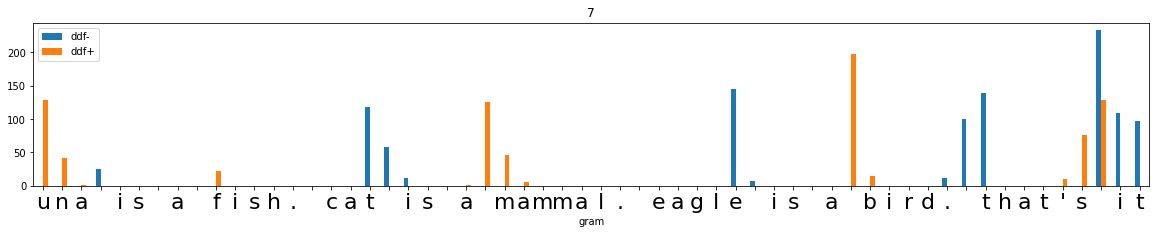

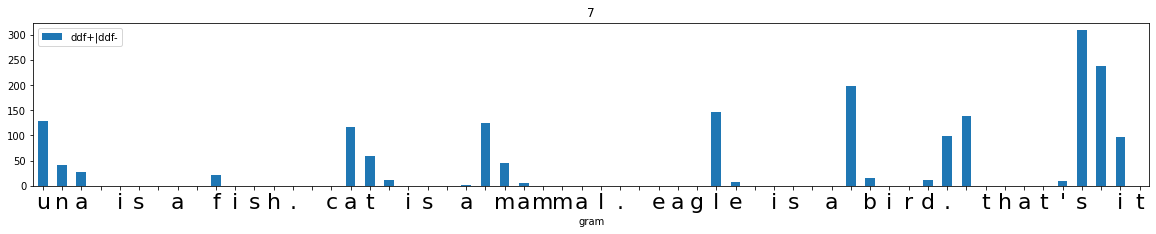

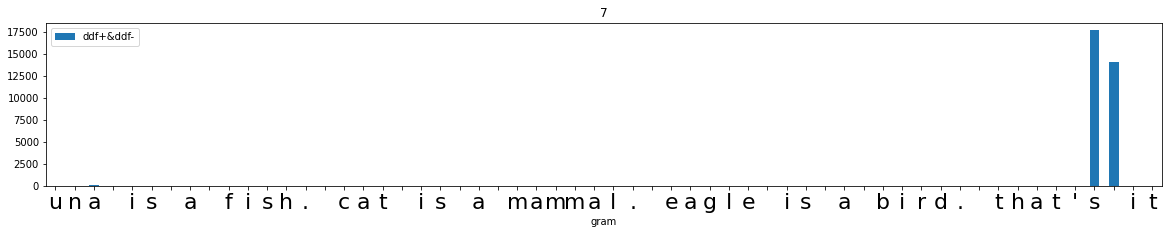

In [99]:
for i in range(1,7+1):
    df = profile_freedoms_ex_df(brown_grams.model,text.lower(),i)
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['ddf+|ddf-'],title=str(i))
    plot_bars(df,'gram',['ddf+&ddf-'],title=str(i))
    #plot_bars(df,'gram',['df-','df+'],title=str(i))
    #plot_bars(df,'gram',['df+|df-'],title=str(i))
    #plot_bars(df,'gram',['df+&df-'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))
    #plot_bars(df,'gram',['f+|f-'],title=str(i))
    #plot_bars(df,'gram',['f+&f-'],title=str(i))


In [35]:
len(brown_to.model[1]['u'])


42

In [36]:
#TODO
def perplexity(dic):
    return len(dic)

perplexity({'the':100,'a':'50','an':10,'that':2,'this':1})


5